## 1. Setup and Data Loading

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [30]:
# Load preprocessed data
df = pd.read_csv('preprocessed_final.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Dataset loaded: {df.shape}")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
df.head()

Dataset loaded: (1785, 68)
Date range: 1996-06-13 to 2020-02-27


,date,next_trading_day,speaker,Positive,Negative,Polarity,LM_pos_rate,LM_neg_rate,LM_net_polarity_per_token,fomc_hawk,...,target_NDQ_1d,target_NDQ_5d,class_SP500_1d,class_SP500_5d,class_RSL_1d,class_RSL_5d,class_DJIA_1d,class_DJIA_5d,class_NDQ_1d,class_NDQ_5d
0,1996-12-19,1996-12-20,Vice Chair Alice M. Rivlin,50,88,-0.275362,0.029638,0.052164,-0.022525,0.000294,...,-0.003616,0.009195,Neutral,Neutral,Neutral,Neutral,Bearish,Neutral,Neutral,Neutral
1,1996-12-06,1996-12-09,Chairman Alan Greenspan,59,70,-0.085271,0.046975,0.055732,-0.008758,0.099280,...,0.002247,-0.027768,Neutral,Bearish,Neutral,Bearish,Bearish,Bearish,Neutral,Bearish
2,1996-12-05,1996-12-06,Chairman Alan Greenspan,62,137,-0.376884,0.033550,0.074134,-0.040584,0.002163,...,0.014037,-0.003713,Bullish,Bearish,Bullish,Bearish,Bullish,Neutral,Bullish,Neutral
3,1996-12-03,1996-12-04,"Governor Edward W. Kelley, Jr.",36,59,-0.242105,0.028916,0.047390,-0.018474,0.000181,...,0.002653,-0.001117,Neutral,Neutral,Neutral,Neutral,Neutral,Bullish,Neutral,Neutral
4,1996-11-25,1996-11-26,Governor Susan M. Phillips,52,32,0.238095,0.047575,0.029277,0.018298,0.000161,...,0.003671,0.019125,Neutral,Bearish,Neutral,Bearish,Neutral,Neutral,Neutral,Bullish


## 2. Prepare Features and Target

In [31]:
# Define columns
metadata_cols = ['date', 'next_trading_day', 'speaker']
target_cols = [c for c in df.columns if c.startswith('target_') or c.startswith('class_')]
feature_cols = [c for c in df.columns if c not in metadata_cols + target_cols]

print(f"Features: {len(feature_cols)}")
print(f"Targets: {len(target_cols)}")

Features: 49
Targets: 16


In [4]:
# Primary target: S&P 500 next-day classification
primary_target = 'class_SP500_1d'

X = df[feature_cols].copy()
y = df[primary_target].copy()

# Encode target labels
label_mapping = {'Bearish': 0, 'Neutral': 1, 'Bullish': 2}
y_encoded = y.map(label_mapping)

print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y_encoded.shape}")


Target distribution:
class_SP500_1d
Neutral    911
Bullish    491
Bearish    383
Name: count, dtype: int64

Features shape: (1785, 49)
Target shape: (1785,)


In [32]:
# Create binary target: Does speech cause significant movement?
threshold = 0.01

# Create binary target for 5-day movements
df['large_move_5d'] = (df['target_SP500_5d'].abs() > threshold).astype(int)

# Switch to binary target
primary_target = 'large_move_5d'
y = df[primary_target].copy()
y_encoded = y  # Already 0/1, no mapping needed

print(f"\n🎯 ACTIVE TARGET: {primary_target}")
print(f"Target distribution:")
print(f"  Small moves (<1%): {(y==0).sum()} ({(y==0).mean()*100:.1f}%)")
print(f"  Large moves (>1%): {(y==1).sum()} ({(y==1).mean()*100:.1f}%)")
print(f"\nTarget shape: {y_encoded.shape}")


🎯 ACTIVE TARGET: large_move_5d
Target distribution:
  Small moves (<1%): 740 (41.5%)
  Large moves (>1%): 1045 (58.5%)

Target shape: (1785,)


## 2.5. Create Binary "Large Movement" Target

## 3. Train-Test Split (Time-Based)

In [33]:
# 80/20 split, preserving temporal order
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y_encoded.iloc[:split_index]
y_test = y_encoded.iloc[split_index:]

train_dates = df['date'].iloc[:split_index]
test_dates = df['date'].iloc[split_index:]

print(f"Training: {len(X_train)} samples ({train_dates.min().date()} to {train_dates.max().date()})")
print(f"Testing: {len(X_test)} samples ({test_dates.min().date()} to {test_dates.max().date()})")
print(f"\nTraining class distribution:\n{y_train.value_counts().sort_index()}")
print(f"\nTest class distribution:\n{y_test.value_counts().sort_index()}")

Training: 1428 samples (1996-06-13 to 2013-12-16)
Testing: 357 samples (2013-01-04 to 2020-02-27)

Training class distribution:
large_move_5d
0    579
1    849
Name: count, dtype: int64

Test class distribution:
large_move_5d
0    161
1    196
Name: count, dtype: int64


## 4. Feature Scaling

In [34]:
# Logistic Regression requires scaled features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled")
print(f"Mean: {X_train_scaled.mean():.6f}")
print(f"Std: {X_train_scaled.std():.6f}")

Features scaled
Mean: 0.000000
Std: 1.000000


In [35]:
# Apply SMOTE to balance training data BEFORE scaling
from imblearn.over_sampling import SMOTE

print("Original training distribution:")
print(y_train.value_counts().sort_index())

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE:")
print(f"Training samples: {len(X_train)} → {len(X_train_smote)}")
print(f"\nClass distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts().sort_index())

# Now scale the SMOTE data
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

print("\n✅ SMOTE applied and features scaled!")

Original training distribution:
large_move_5d
0    579
1    849
Name: count, dtype: int64

After SMOTE:
Training samples: 1428 → 1698

Class distribution after SMOTE:
large_move_5d
0    849
1    849
Name: count, dtype: int64

✅ SMOTE applied and features scaled!


## 4.5. Apply SMOTE Oversampling

## 5. Baseline Model

In [36]:
# Baseline: Always predict most common class
most_common_class = y_train.mode()[0]
baseline_pred = np.full(len(y_test), most_common_class)
baseline_acc = accuracy_score(y_test, baseline_pred)

print(f"Baseline: Always predict class {most_common_class}")
print(f"Baseline Accuracy: {baseline_acc:.4f}")


Baseline: Always predict class 1
Baseline Accuracy: 0.5490


## 6. Train Logistic Regression

In [37]:
# Train model
lr_model = LogisticRegression(
    multi_class='multinomial',
    max_iter=1000,
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    solver='lbfgs'
)

print("Training Logistic Regression...")
lr_model.fit(X_train_scaled, y_train)
print("✅ Training complete!")

Training Logistic Regression...


ValueError: Found input variables with inconsistent numbers of samples: [1698, 1428]

## 7. Evaluate Performance

In [38]:
# Make predictions
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("="*60)
print("LOGISTIC REGRESSION RESULTS")
print("="*60)
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"\nBaseline:  {baseline_acc:.4f}")
print(f"Improvement: {(acc - baseline_acc)*100:.2f}%")
print("="*60)

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [10]:
# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Bearish', 'Neutral', 'Bullish'], zero_division=0))


Detailed Classification Report:
              precision    recall  f1-score   support

     Bearish       0.14      0.29      0.19        45
     Neutral       0.65      0.30      0.41       232
     Bullish       0.21      0.41      0.28        80

    accuracy                           0.32       357
   macro avg       0.33      0.33      0.29       357
weighted avg       0.49      0.32      0.35       357



## 8. Confusion Matrix

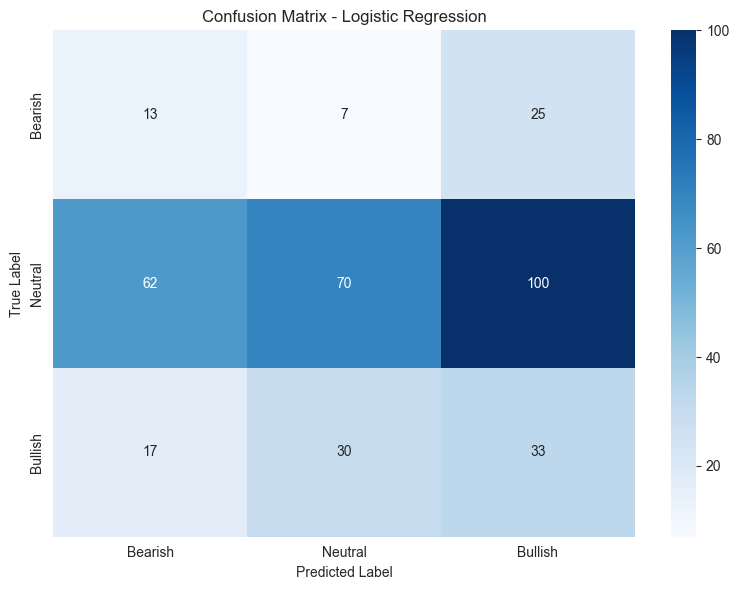

Confusion Matrix:
[[ 13   7  25]
 [ 62  70 100]
 [ 17  30  33]]


In [11]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bearish', 'Neutral', 'Bullish'],
            yticklabels=['Bearish', 'Neutral', 'Bullish'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("Confusion Matrix:")
print(cm)

## 9. Feature Coefficients

In [12]:
# Get coefficients for each class
# For multinomial, we have separate coefficients for each class
coef_df = pd.DataFrame(
    lr_model.coef_.T,
    index=feature_cols,
    columns=['Bearish', 'Neutral', 'Bullish']
)

# Get overall importance (average absolute coefficient)
coef_df['abs_importance'] = coef_df.abs().mean(axis=1)
coef_df = coef_df.sort_values('abs_importance', ascending=False)

print("Top 20 Most Important Features:")
print(coef_df.head(20))

Top 20 Most Important Features:
                            Bearish   Neutral   Bullish  abs_importance
SP500_vol_20d             -0.218840 -0.625443  0.844283        0.562855
RSL_vol_20d                0.534805  0.298022 -0.832827        0.555218
RSL_ret_1d                 0.277829  0.255076 -0.532905        0.355270
RSL_ret_20d                0.419049  0.102714 -0.521763        0.347842
Polarity                   0.448446 -0.393608 -0.054838        0.298964
NDQ_ret_5d                -0.056093  0.443606 -0.387514        0.295738
n_tokens                  -0.220868 -0.207618  0.428486        0.285658
SP500_ret_20d             -0.393326  0.164352  0.228975        0.262217
year                       0.118732  0.236017 -0.354749        0.236499
NDQ_vol_20d               -0.160802 -0.177290  0.338092        0.225395
Positive                   0.117139  0.216455 -0.333594        0.222396
unemployment              -0.015966  0.329379 -0.313414        0.219586
RSL_ret_5d                 0.118

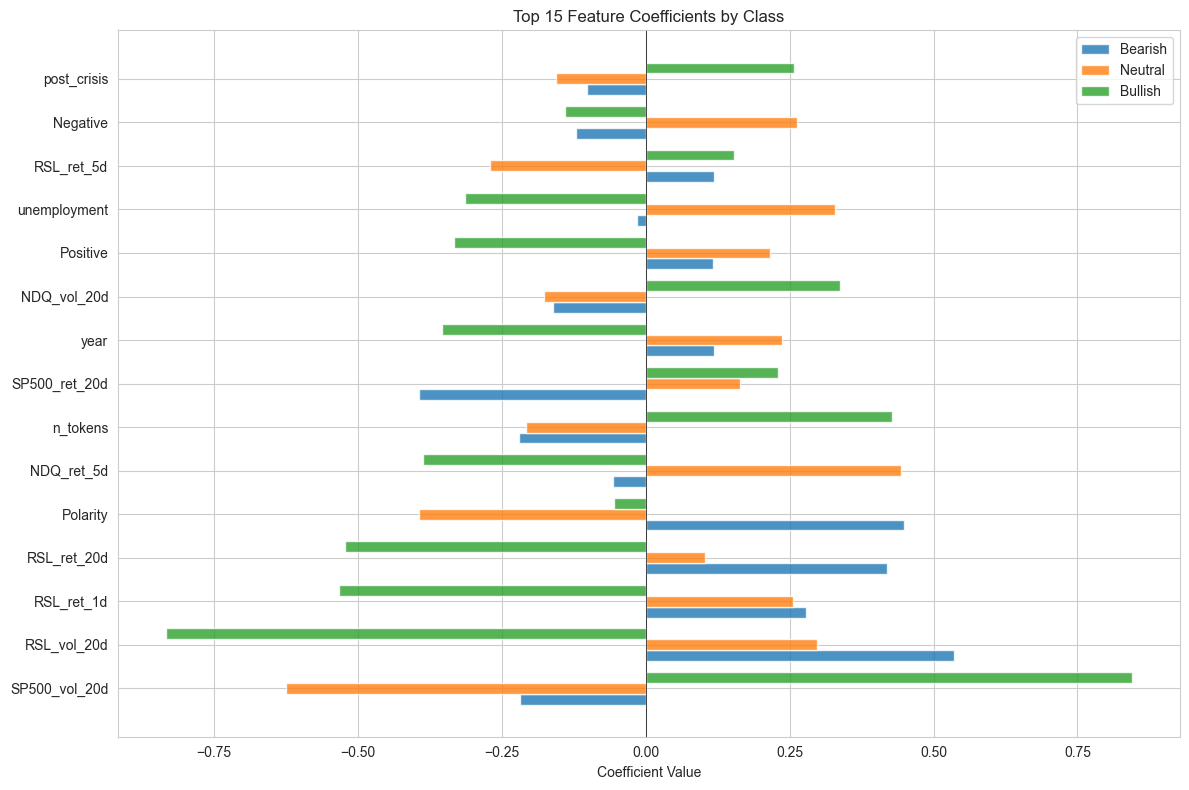

In [13]:
# Visualize top 15 feature coefficients
top_15 = coef_df.head(15)

fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(top_15))
width = 0.25

ax.barh(x - width, top_15['Bearish'], width, label='Bearish', alpha=0.8)
ax.barh(x, top_15['Neutral'], width, label='Neutral', alpha=0.8)
ax.barh(x + width, top_15['Bullish'], width, label='Bullish', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(top_15.index)
ax.set_xlabel('Coefficient Value')
ax.set_title('Top 15 Feature Coefficients by Class')
ax.legend()
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

## 10. Time Series Cross-Validation

In [14]:
# Perform 5-fold time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

print("Performing Time Series Cross-Validation...\n")

cv_scores = []
fold_num = 1

for train_idx, val_idx in tscv.split(X):
    X_train_cv = scaler.fit_transform(X.iloc[train_idx])
    X_val_cv = scaler.transform(X.iloc[val_idx])
    y_train_cv = y_encoded.iloc[train_idx]
    y_val_cv = y_encoded.iloc[val_idx]
    
    # Train model
    lr_cv = LogisticRegression(
        multi_class='multinomial',
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    )
    lr_cv.fit(X_train_cv, y_train_cv)
    
    # Evaluate
    y_pred_cv = lr_cv.predict(X_val_cv)
    acc_cv = accuracy_score(y_val_cv, y_pred_cv)
    f1_cv = f1_score(y_val_cv, y_pred_cv, average='weighted', zero_division=0)
    
    cv_scores.append({'fold': fold_num, 'accuracy': acc_cv, 'f1': f1_cv})
    print(f"Fold {fold_num}: Accuracy = {acc_cv:.4f}, F1 = {f1_cv:.4f}")
    fold_num += 1

cv_df = pd.DataFrame(cv_scores)
print(f"\n{'='*60}")
print(f"Cross-Validation Summary:")
print(f"Mean Accuracy: {cv_df['accuracy'].mean():.4f} (+/- {cv_df['accuracy'].std():.4f})")
print(f"Mean F1 Score: {cv_df['f1'].mean():.4f} (+/- {cv_df['f1'].std():.4f})")
print(f"{'='*60}")

Performing Time Series Cross-Validation...

Fold 1: Accuracy = 0.3805, F1 = 0.3050
Fold 2: Accuracy = 0.4714, F1 = 0.4574
Fold 3: Accuracy = 0.5253, F1 = 0.4447
Fold 4: Accuracy = 0.4377, F1 = 0.3987
Fold 5: Accuracy = 0.3569, F1 = 0.4051

Cross-Validation Summary:
Mean Accuracy: 0.4343 (+/- 0.0681)
Mean F1 Score: 0.4022 (+/- 0.0598)


## 11. Save Results

In [15]:
# Save predictions
test_results = df.iloc[split_index:].copy()
test_results['true_class'] = y_test
test_results['predicted_class'] = y_pred
test_results['correct'] = (y_test == y_pred).astype(int)

# Add probability scores
test_results['prob_bearish'] = y_pred_proba[:, 0]
test_results['prob_neutral'] = y_pred_proba[:, 1]
test_results['prob_bullish'] = y_pred_proba[:, 2]

predictions_df = test_results[[
    'date', 'speaker', 'true_class', 'predicted_class', 'correct',
    'prob_bearish', 'prob_neutral', 'prob_bullish'
]]
predictions_df.to_csv('logistic_regression_predictions.csv', index=False)
print("✅ Predictions saved: logistic_regression_predictions.csv")

# Save feature coefficients
coef_df.to_csv('logistic_regression_coefficients.csv')
print("✅ Coefficients saved: logistic_regression_coefficients.csv")

# Save model
import pickle
with open('logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Model saved: logistic_regression_model.pkl")
print("✅ Scaler saved: scaler.pkl")

✅ Predictions saved: logistic_regression_predictions.csv
✅ Coefficients saved: logistic_regression_coefficients.csv
✅ Model saved: logistic_regression_model.pkl
✅ Scaler saved: scaler.pkl


## 12. Summary

In [16]:
print("="*80)
print("LOGISTIC REGRESSION - FINAL SUMMARY")
print("="*80)
print(f"\n📊 Model: Multinomial Logistic Regression")
print(f"🎯 Target: S&P 500 Next-Day Direction (Bearish/Neutral/Bullish)")
print(f"\n📈 Performance:")
print(f"  - Test Accuracy: {acc:.4f}")
print(f"  - Baseline: {baseline_acc:.4f}")
print(f"  - Improvement: {(acc - baseline_acc)*100:.2f}%")
print(f"  - F1 Score: {f1:.4f}")
print(f"\n🔄 Cross-Validation:")
print(f"  - Mean Accuracy: {cv_df['accuracy'].mean():.4f}")
print(f"  - Std: {cv_df['accuracy'].std():.4f}")
print(f"\n💡 Interpretation:")
if acc > baseline_acc + 0.05:
    print("  ✅ Model shows predictive power!")
elif acc > baseline_acc:
    print("  ⚠️  Weak signal detected.")
else:
    print("  ❌ No improvement over baseline.")
print("\n" + "="*80)

LOGISTIC REGRESSION - FINAL SUMMARY

📊 Model: Multinomial Logistic Regression
🎯 Target: S&P 500 Next-Day Direction (Bearish/Neutral/Bullish)

📈 Performance:
  - Test Accuracy: 0.3249
  - Baseline: 0.6499
  - Improvement: -32.49%
  - F1 Score: 0.3544

🔄 Cross-Validation:
  - Mean Accuracy: 0.4343
  - Std: 0.0681

💡 Interpretation:
  ❌ No improvement over baseline.

